In [1]:
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import functools
import random_graph
import random_fields
import random
import numpy as np
from matplotlib import rc
rc('text', usetex=True)
sns.set(font='serif', style='white')

In [2]:
names = ['S'+str(i) for i in range(16)]
on = random.sample(names, 6)
test_data = {name:name in on for name in names}
coords = random_graph.generate_sorted_grid_coords(16)

In [3]:
def get_color(cmap, val, minval=0,maxval=1):
    assert minval<=val<=maxval
    factor = (maxval-minval)*255
    return cmap(int(factor*val))
def contrast_text(background):
    r,g,b,a = [int(255*i) for i in background]
    brightness = (r*299+g*587+b*114)/1000
    return "#ffffff" if brightness<175 else '#252525'
def add_grid_lines(coords, ax, linewidth=1):
    xs =set([x for x,y in coords])
    ys = set([y for x,y in coords])
    top_coords = list(itertools.product(xs, [max(ys)]))
    top_extensions = [[(x,y),(x,y+7)] for x,y in top_coords]
    bottom_coords = list(itertools.product(xs, [min(ys)]))
    bottom_extensions = [[(x,y),(x,y-7)] for x,y in bottom_coords]
    right_coords= list(itertools.product([max(xs)], ys))
    left_coords = list(itertools.product([min(xs)], ys)) 
    left_extensions = [[(x,y),(x-7,y)] for x,y in left_coords]
    right_extensions = [[(x,y),(x+7,y)] for x,y in right_coords]
    verticals = [list(itertools.product([x],ys)) for x in xs]
    horizs = [list(itertools.product(xs,[y])) for y in ys]
    for line in (horizs
                 +verticals
                 +top_extensions
                 +bottom_extensions
                 +left_extensions
                 +right_extensions):
        sorted_line = sorted([(x,y) for x,y in line], key = lambda i :i[0]*i[1])
        ax.plot([x for x,y in sorted_line],
                [y for x,y in sorted_line],
                color ="#969696",linewidth=linewidth,zorder =1, linestyle ='--')
    return ax
def heatplot(data,abs_coords,ax, fig, topcorner=(0,0),s=300, named=True, legend=False):
    #print(data)
    """
    data: {'S0':p0,'S1':p1...} where p1..pn is the probability of being in that state
    """
    xoffset = 0-topcorner[0]
    yoffset = 0-topcorner[1]
    coords = [(x+xoffset, y+yoffset) for x,y in abs_coords]
    name_to_num = lambda s:int(s[1::])
    stringifier = lambda s: str(s) if len(str(s))==2 else ' '+str(s)        
    cmap=plt.get_cmap("Greys")
    our_colors = functools.partial(get_color, cmap)
    ps = [data['S'+str(idx)] for idx,v in enumerate(coords)]
    sc = ax.scatter([x for x,y in coords],[y for x,y in coords],c=ps ,vmin=0,vmax=1,
               edgecolor='#525252', linewidth=1,s=s, cmap=cmap, zorder=2)
    if legend:
        ax.scatter([x for x,y in coords][0],[y for x,y in coords][0],c='#000000',
               edgecolor="#525252", linewidth=1,s=100,zorder=0, label='Active node')
        ax.scatter([x for x,y in coords][1],[y for x,y in coords][1],c='#ffffff',
               edgecolor="#525252", linewidth=1,s=100,zorder=0, label='Idle node')
    if named:
        for idx,(x,y) in enumerate(coords):
            val = data['S'+str(idx)]
            color = our_colors(val)
            ax.text(x,y, str(idx), color=contrast_text(color),horizontalalignment='center'
                ,verticalalignment='center', fontsize=11)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    #ax_cbar = fig.add_axes([1, 0.2, 0.1, 0.6])
    #ax_cbar = fig.add_axes([0.2,0,0.6,0.1])
    #cbar = plt.colorbar(sc, ax = ax_cbar, orientation='horizontal', fraction=1,label='Proportion of time active',
    #                    ticks=[0,0.2,0.4,0.6,0.8,1])
    #cbar.outline.set_visible(False)
    #cbar.ax.tick_params(direction='out', length=2, width=0.5, colors='#525252',
    #           grid_color='#525252', grid_alpha=0.5)
    #ax_cbar.axes.get_xaxis().set_visible(False)
    #ax_cbar.axes.get_yaxis().set_visible(False)
    #ax_cbar.set_yticklabels([])
    return ax

In [4]:
def custom_gridder(small, big, size=1):
    xs = ys = np.arange(start= small, stop=big, step=size)
    return list(itertools.product(xs, ys))

In [5]:
small, big = -6,37
square = custom_gridder(small, big, size=1)
smoothcov = functools.partial(random_fields.iso_cov, 128)
cov_matrix = random_fields.form_cov_matrix(square, smoothcov)

In [100]:
perturbation = random_fields.simulate(cov_matrix)
mat = random_fields.to_mat(square, perturbation)

1849 1849


In [101]:
xoffset,yoffset = 6,6
offset_coords = [(x+xoffset, y+yoffset) for x,y in coords]
conns = random_graph.soft_geometric_graph(offset_coords, r_char=16)
on_nodes = [int(i[1::]) for i,on in test_data.items() if on]
filtered_conns = [(source,dest) for source, dest in conns if source in on_nodes]
connected = [(offset_coords[s1], offset_coords[s2]) for s1,s2 in filtered_conns]

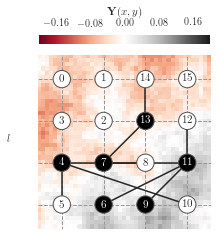

In [110]:
fig, ax = plt.subplots(1)
fig.set_size_inches(3.5,4)
ax = heatplot(test_data, coords, ax, fig, topcorner=(-6,-6))
ax = add_grid_lines(offset_coords, ax)
ax = sns.heatmap(mat,ax=ax,square=True,vmin=-0.2,vmax=0.2,cmap='RdGy',
                 cbar_kws = dict(use_gridspec=False,location="top",shrink=0.88,label=r"$\mathbf{Y}(x,y)$"
))
for idx,(s1,s2) in enumerate(connected):
    label = 'Peer to peer connection' if idx==0 else ''
    ax.plot([s1[0],s2[0]],[s1[1],s2[1]], c='#252525', alpha=1, zorder=1, linestyle='-', linewidth=1.5, label=label)
ax.plot([-5,-5],[6,37], linestyle='-', linewidth=0.5, color ='#525252',zorder=100)
ax.text(-7.5,21.5,'$l$')
#ax.arrow(x=-5,y=8,dx=0,dy=-0.5, width=0.35, color ='#525252')
#ax.arrow(x=-5,y=36.25,dx=0,dy=0.5, width=0.25,color ='#525252')

##ax.set_aspect('equal')
#ax.legend()
#sns.despine(left=True, bottom=True, top=True,right=True)
#fig.tight_layout()
fig.savefig('basefigure.png', dpi=600, transparent=True)

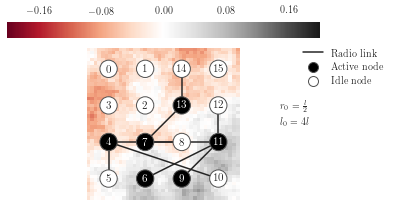

In [107]:
fig, ax = plt.subplots(1)
fig.set_size_inches(7,3.5)
ax = heatplot(test_data, coords, ax, fig, topcorner=(-6,-6), legend=True)
ax = sns.heatmap(mat,ax=ax,square=True,vmin=-0.2,vmax=0.2,cmap='RdGy',cbar_kws = dict(use_gridspec=False,location="top",shrink=0.8))
for idx,(s1,s2) in enumerate(connected):
    label = 'Radio link' if idx==0 else ''
    ax.plot([s1[0],s2[0]],[s1[1],s2[1]], c='#252525', alpha=1, zorder=1, linestyle='-', linewidth=1.5, label=label)
#ax.scatter([50],[25],s=300)
leg = ax.legend(bbox_to_anchor=(2, 1.05), fontsize=10)
ax.text(54.5,18 ,r'$r_0=\frac{l}{2}$', fontsize=10)
ax.text(54.5,22 ,r'$l_0= 4l$', fontsize=10)
leg.get_frame().set_linewidth(0.0)
fig.savefig('legend.png', dpi=600,transparent=True)

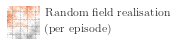

In [105]:
fig,ax = plt.subplots(1)
fig.set_size_inches(0.75,0.75)
ax = sns.heatmap(mat,ax=ax,square=True,cmap='RdGy',cbar=False,vmin=-0.2,vmax=0.2)
add_grid_lines(offset_coords,ax, linewidth=0.5)
sns.despine()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
sns.despine(left=True, bottom=True)
ax.text(50,33,'Random field realisation \n (per episode)',fontsize=12)
fig.tight_layout()
fig.savefig('randomfieldlegend.png',dpi=600,transparent=True)

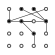

In [111]:
fig,ax = plt.subplots(1)
fig.set_size_inches(0.75,0.75)
ax = heatplot(test_data, coords, ax, fig, topcorner=(-6,-6), s=10,named=False)#sns.heatmap(mat,ax=ax,square=True,cmap='RdGy',cbar=False)
ax.set_aspect('equal')
#add_grid_lines(offset_coords,ax, linewidth=0.75)
for idx,(s1,s2) in enumerate(connected):
    label = 'Peer to peer connection' if idx==0 else ''
    ax.plot([s1[0],s2[0]],[s1[1],s2[1]], c='#252525', alpha=1, zorder=1, linestyle='-', linewidth=0.5, label=label)
sns.despine()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
sns.despine(left=True, bottom=True)
#ax.text(50,20,'Random graph realisation \n (per epoch)',fontsize=12)

#ax.text(50,25,'Random field realisation \n (per episode)',fontsize=10)
fig.savefig('networklegend.png', dpi=600, transparent=True)

In [ ]:
offset_coords